<a href="https://colab.research.google.com/github/Hanyan-Wu/MachineLearningLab/blob/main/RNNmodel_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1.) Import an asset price from Yahoo Finance

In [1]:
pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import yfinance as yf
import numpy as np
import pandas as pd

In [3]:
########################################
####Pick your ticker and time period####
########################################

stock_data = yf.download("F", start="1990-01-01", end="2022-02-21")


# Preprocess data
scaled_data = np.array(stock_data["Close"].pct_change().dropna()).reshape(-1,1)


# Split data into training and test sets
training_data_len = int(len(scaled_data) * 0.8)
train_data = scaled_data[0:training_data_len, :]

[*********************100%***********************]  1 of 1 completed


# 2.) Create your x_train/y_train data so that your RNN uses percentage change data to make a binary forecast where the stock moves up or down the next day
# Build an RNN Architecture accordingly

In [4]:
train_data

array([[ 0.00552474],
       [ 0.        ],
       [-0.01373619],
       ...,
       [-0.00145663],
       [ 0.00510574],
       [ 0.03846159]])

In [5]:
x_train = []
y_train = []

#############################################################
####Pick your input size and edit to make binary forecast####
#############################################################
input_size = 5 # number of lags 5 10 20 50 ...
for i in range(input_size, len(train_data)):
    x_train.append(train_data[i-input_size:i, 0])
    y_train.append(train_data[i, 0])

In [6]:
y_train[:5]

[0.008498632221580982,
 0.011235940540534894,
 -0.02777791650034478,
 -0.011428558458832505,
 0.04046256255464575]

In [7]:
# # if y_train[i] > 0 --> 1, if y_train[i] <= 0 --> 0 (using np.where)
y_train = np.where(np.array(y_train) > 0, 1, 0)
y_train[:5]

array([1, 1, 0, 0, 1])

In [8]:
x_train = np.array(x_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [9]:
x_train[:5]

array([[[ 0.00552474],
        [ 0.        ],
        [-0.01373619],
        [ 0.        ],
        [-0.01671307]],

       [[ 0.        ],
        [-0.01373619],
        [ 0.        ],
        [-0.01671307],
        [ 0.00849863]],

       [[-0.01373619],
        [ 0.        ],
        [-0.01671307],
        [ 0.00849863],
        [ 0.01123594]],

       [[ 0.        ],
        [-0.01671307],
        [ 0.00849863],
        [ 0.01123594],
        [-0.02777792]],

       [[-0.01671307],
        [ 0.00849863],
        [ 0.01123594],
        [-0.02777792],
        [-0.01142856]]])

In [10]:
# from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

In [11]:
x_train.shape

(6472, 5, 1)

In [12]:
###################################
####Build Your RNN Architecture####
###################################
model = Sequential()

# First layer --> LSTM layer
model.add(LSTM(x_train.shape[1], return_sequences=True, input_shape=(x_train.shape[1], 1)))

# Adding more LSTM layers and perceptron layers
## LSTM layers take in as sequence, the dense layers do not take in sequences
## Also where to put in drop out percentages

model.add(LSTM(20, return_sequences=True))
model.add(Dropout(0.2)) # Add a dropout layer with a dropout rate of 0.2

model.add(LSTM(10, return_sequences=False))
model.add(Dropout(0.1))

model.add(Dense(25))
model.add(Dense(5))

# Classification: choose your activation function
## for the last layer --> output = 0 or 1
model.add(Dense(1, activation='sigmoid'))


model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size=1, epochs=3)

Epoch 1/3
6472/6472 [==============================] - 69s 9ms/step - loss: 0.2496
Epoch 2/3
6472/6472 [==============================] - 57s 9ms/step - loss: 0.2494
Epoch 3/3
6472/6472 [==============================] - 55s 9ms/step - loss: 0.2494


# 3.) Test your model and compare insample Accurracy, insample random walk assumption Accuracy, Out of sample Accuracy and out of sample random walk assumption Accuracy using a bar chart

In [13]:
# Subset test data
test_data = scaled_data[training_data_len - input_size:, :]

# x_test
x_test = []

for i in range(input_size, len(test_data)):
    x_test.append(test_data[i-input_size:i, 0])


x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [14]:
x_test[:5]

array([[[-0.01024143],
        [ 0.01478195],
        [-0.00145663],
        [ 0.00510574],
        [ 0.03846159]],

       [[ 0.01478195],
        [-0.00145663],
        [ 0.00510574],
        [ 0.03846159],
        [ 0.02306079]],

       [[-0.00145663],
        [ 0.00510574],
        [ 0.03846159],
        [ 0.02306079],
        [-0.00273224]],

       [[ 0.00510574],
        [ 0.03846159],
        [ 0.02306079],
        [-0.00273224],
        [-0.02191785]],

       [[ 0.03846159],
        [ 0.02306079],
        [-0.00273224],
        [-0.02191785],
        [ 0.00280112]]])

In [15]:
# y_test
y_test = np.array(stock_data[["Close"]].pct_change().dropna())[training_data_len:, :]

In [16]:
y_test[:5]

array([[ 0.02306079],
       [-0.00273224],
       [-0.02191785],
       [ 0.00280112],
       [-0.02793293]])

In [17]:
y_test = np.array(np.where(np.array(y_test) > 0, 1, 0))

In [18]:
y_test = [sublist[0] for sublist in list(y_test)]
y_test[:5]

[1, 0, 0, 1, 0]

In [19]:
# Make predictions
predictions = model.predict(x_test)

51/51 [==============================] - 2s 4ms/step


In [20]:
# Make classifications
y_pred = np.round(predictions)
np.unique(y_pred, return_counts=True)

(array([0.], dtype=float32), array([1620]))

In [21]:
# Record training set predictions
y_pred_in = np.round(model.predict(x_train))
np.unique(y_pred_in, return_counts=True)

203/203 [==============================] - 1s 4ms/step


(array([0.], dtype=float32), array([6472]))

In [22]:
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

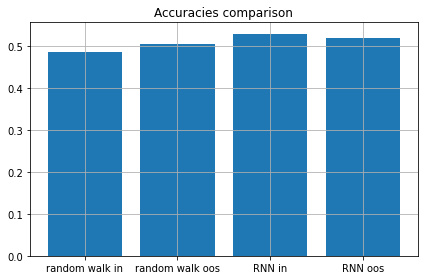

In [23]:
# IN random walk model accuracy
acc_ran_in = accuracy_score(y_train[1:], y_train[:-1])

# OOS Random walk model accuracy
acc_ran_out = accuracy_score(y_test[1:], y_test[:-1])

# IN model accuracy
acc_in = accuracy_score(y_train, y_pred_in)

# OOS model accuracy
acc_out = accuracy_score(y_test, y_pred)

# Plot the accuracies
plt.title('Accuracies comparison')
plt.bar(['random walk in', 'random walk oos', 'RNN in', 'RNN oos'],
        [acc_ran_in, acc_ran_out, acc_in, acc_out])
plt.grid()
plt.tight_layout()

# DONT DO 4.) Plot in and out of sample accuracy

In [24]:
# import matplotlib.pyplot as plt

# Make predictions on full dataset

# test_predict = model.predict(x_test)
# test_predictions = (test_predict+1).reshape(1,-1) * np.cumprod(y_test+1)

# train_predict = model.predict(x_train)
# train_predictions = (train_predict+1).reshape(1,-1) * np.cumprod(y_train+1)



# plt.plot(stock_data[:training_data_len- input_size].index, np.cumprod(y_train+1), label="Training Data")
# plt.plot(stock_data[:training_data_len- input_size].index, train_predictions[0], label="Training Predictions")
# end_val = np.cumprod(y_train+1)[-1]
# test_predict = model.predict(x_test)
# test_predictions = (test_predict+1).reshape(1,-1) * (np.cumprod((y_test+1))*end_val)
# plt.plot(stock_data[training_data_len+1:].index, np.cumprod((y_test+1))*end_val,label="Test Data")
# plt.plot(stock_data[training_data_len+1:].index, test_predictions[0], label="Test Predictions")
# plt.xlabel("Date")
# plt.ylabel("Stock Price")
# plt.legend()
# plt.show()

# 5.) Write an observation/conclusion about the graphs from Q4 and Q3

The accuracies of the RNN model are not very good, only narrowly beat the random walk accuracies. This is probably because the stock market in the US is at least semi-form strong, prediction using only historical data could harldly be accurate. 

# 6.) Create a parameter for number of lags in your input layer. Do a 3-fold CV to test three different time lags. i.e. Tested using 5,10,20 days of previous price data to forecast

In [25]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from keras.wrappers.scikit_learn import KerasRegressor

In [26]:
# Define the Keras model
def create_model(input_size):
    # # Gloablally change the inputs
    # x_train = []
    # y_train = []

    # for i in range(input_size, len(train_data)):
    #     x_train.append(train_data[i-input_size:i, 0])
    #     y_train.append(train_data[i, 0])

    # x_train, y_train = np.array(x_train), np.array(y_train)
    # y_train = np.where(y_train > 0, 1, 0)

    # Model constructed in Q2
    model_cv = Sequential()

    model_cv.add(LSTM(x_train.shape[1], return_sequences=True, input_shape=(x_train.shape[1], 1)))

    model_cv.add(LSTM(20, return_sequences=True))
    model_cv.add(Dropout(0.2)) # Add a dropout layer with a dropout rate of 0.2

    model_cv.add(LSTM(10, return_sequences=False))
    model_cv.add(Dropout(0.1))

    model_cv.add(Dense(25))
    model_cv.add(Dense(5))
    model_cv.add(Dense(1, activation='sigmoid'))

    model_cv.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

    return model_cv

In [29]:
def get_modified_data(param_dict):
    # modify x_train and y_train based on the hyperparameters in param_dict
    input_size = param_dict['input_size']
    
    new_x_train = []
    new_y_train = []

    for i in range(input_size, len(train_data)):
        new_x_train.append(train_data[i-input_size:i, 0])
        new_y_train.append(train_data[i, 0])

    new_x_train, new_y_train = np.array(new_x_train), np.array(new_y_train)
    new_y_train = np.where(new_y_train > 0, 1, 0)

    return new_x_train, new_y_train

# define the Keras model
model_keras = KerasRegressor(build_fn=create_model, verbose=0)

# define the parameter grid
param_grid = {
    'epochs': [1],
    'input_size': [5, 10, 20]
    }

# define the GridSearchCV object
grid = GridSearchCV(estimator=model_keras, param_grid=param_grid, cv=3, pre_dispatch=get_modified_data)

# fit the GridSearchCV object
grid_result = grid.fit(x_train, y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

<ipython-input-29-761b50912e18>:18: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model_keras = KerasRegressor(build_fn=create_model, verbose=0)


Best: -0.249376 using {'epochs': 1, 'input_size': 20}
